---

## Библиотеки и пакеты

---

In [1]:
using SciMLBase

using DiffEqCallbacks
using DifferentialEquations

using DynamicalSystems

using StaticArrays

using Plots

using Latexify
using LaTeXStrings

using ProgressMeter

In [2]:
using JLD

In [3]:
using BenchmarkTools

In [4]:
using ColorSchemes

In [5]:
include("Utils\\Visualization_Utils.jl"); using .Visualization_Utils
include("Utils\\Computation_Utils.jl"); using .Computation_Utils
include("Utils\\CallBack_Utils.jl"); using .CallBack_Utils
include("ODEs\\BS_ODE.jl"); using .BS_ODE
include("ODEs\\BS_Transformed_ODE.jl"); using .BS_Transformed_ODE
include(raw"Utils\Bifurcation_Utils.jl")
include(raw"Utils\Inheritance_Utils.jl")

In [6]:
#md = MatcontData("matcont_data/new_diagram")
md = MatcontData("matcont_data/diagram")

MatcontData(MatcontCurve[MatcontCurve([3.5217930541225875 3.521925925562598 … 3.9239585526873575 3.9243059424825764; -3.672111953233036 -3.6723308716268184 … -4.871030135939884 -4.872978722427839; … ; 203.55262580985345 203.55876452052976 … 248.58814428449693 248.67040940736376; 0.10411966251181297 0.1041179888827162 … 0.09838687714992365 0.09838086046921277], Dict{String, Any}("label" => Any["00"; "NS "; "99";;], "internallabel" => Any[Matrix{Float64}(undef, 0, 0); Matrix{Float64}(undef, 0, 0); Matrix{Float64}(undef, 0, 0);;], "msg" => Any["This is the first point of the curve"; "Neimark Sacker"; "This is the last point on the curve";;], "data" => Any[Dict{String, Any}("timemesh" => [0.0 0.03225681690519989 … 0.9726737034677198 1.0], "T" => 203.55262580985345, "ncol" => 4.0, "ntst" => 40.0, "phi" => [0.40824829046386296 0.40824829046386296 … 0.40824829046386296 0.40824829046386296], "multipliers" => ComplexF64[7.934764757484228e-12 + 0.0im; 1.658002501797894e-9 + 0.0im; … ; -0.1416913

---

### Вспомогательные функции

---

In [7]:
function get_sol_endstate(ODE, ic, time_span, P, callback; alg = DP8(), kwargs...)
    prob_julia = ODEProblem(ODE, ic, time_span, P)
    sol = solve(prob_julia, alg; callback, kwargs...)#, save_everystep = false

    if sol.retcode == ReturnCode.Success
        return sol
    else
        return nothing
    end
end

get_sol_endstate (generic function with 1 method)

In [8]:
@inbounds function f(u, p, t)
    u /= 2.0
    x1, x2, x3, y1, y2, y3 = u
    A, B, C, Eps = p

    th1, th2, th3, th4, th5, th6 = tanh.(u)
    sh1, sh2, sh3, sh4, sh5, sh6 = sinh.(u)

    dx1 = 2.0 * (A * (th2 - th3) - B * th1 + C) - Eps * (sech(y1) * sh1 - th4)
    dx2 = 2.0 * (A * (th3 - th1) - B * th2 + C) - Eps * (sech(y2) * sh2 - th5) 
    dx3 = 2.0 * (A * (th1 - th2) - B * th3 + C) - Eps * (sech(y3) * sh3 - th6)
    dy1 = 2.0 * (-A * (th5 - th6) - B * th4 + C) - Eps * (sech(x1) * sh4 - th1)
    dy2 = 2.0 * (-A * (th6 - th4) - B * th5 + C) - Eps * (sech(x2) * sh5 - th2)
    dy3 = 2.0 * (-A * (th4 - th5) - B * th6 + C) - Eps * (sech(x3) * sh6 - th3)

    return SVector{6}(dx1, dx2, dx3, dy1, dy2, dy3)
end

f (generic function with 1 method)

In [9]:
@inbounds function w(u, p, t)
    x1, x2, x3, y1, y2, y3 = u
    A, B, C, Eps = p

    th1, th2, th3, th4, th5, th6 = tanh.(u)
    sh1, sh2, sh3, sh4, sh5, sh6 = sinh.(u)

    dx1 = (A * (th2 - th3) - B * th1 + C) - Eps * (sech(y1) * sh1 - th4)
    dx2 = (A * (th3 - th1) - B * th2 + C) - Eps * (sech(y2) * sh2 - th5) 
    dx3 = (A * (th1 - th2) - B * th3 + C) - Eps * (sech(y3) * sh3 - th6)
    dy1 = (-A * (th5 - th6) - B * th4 + C) - Eps * (sech(x1) * sh4 - th1)
    dy2 = (-A * (th6 - th4) - B * th5 + C) - Eps * (sech(x2) * sh5 - th2)
    dy3 = (-A * (th4 - th5) - B * th6 + C) - Eps * (sech(x3) * sh6 - th3)

    return SVector{6}(dx1, dx2, dx3, dy1, dy2, dy3)
end

w (generic function with 1 method)

In [10]:
#test_ic = SVector{6}(rand(6))
#@benchmark w(test_ic, P, 0.0)

---

## Параметры карты

---

In [11]:
len = 50

time_span = 20_000
trans_time = 5_000.0

ODE = w

A = -0.05977203237457928
B = -0.06740280698747875
C = 0.0
Eps = (0.10412315329959422-0.001) / 2.0

P = [A, B, C, Eps]

ic = SA[ 3.521793060633561
        -3.672631369572926
        -3.9610473751593673
        1.7522938030855033
        -5.767907042997395
        2.1177439994225145] ./ 2.0

A_ls = range(-0.063, -0.0585, length = len)
Eps_ls = range(0.1 / 2.0, 0.109 / 2.0, length = len)

icpm = ICPMEsh(A_ls[begin], A_ls[end], Eps_ls[begin], Eps_ls[end], (A, Eps, ic), len)

A_ls = [a[1] for a in icpm.p_mesh[:, 1]]
Eps_ls = [a[2] for a in icpm.p_mesh[1, :]];

In [12]:
ic

6-element SVector{6, Float64} with indices SOneTo(6):
  1.7608965303167805
 -1.836315684786463
 -1.9805236875796837
  0.8761469015427517
 -2.8839535214986975
  1.0588719997112572

In [13]:
a4 = pi
a2 = pi/2

K = A / cos(a4)
r = B / (4.0cos(2.0a2))

0.016850701746869687

In [25]:
r/K

0.28191615840113543

In [26]:
K

0.05977203237457928

In [15]:
Eps

0.05156157664979711

In [56]:
## Numerical parameters ##
#alg = DP8()
#alg = RK4()
alg = Tsit5()
#alg = AutoVern9(Rodas4())
#alg = TRBDF2(autodiff=false)
#alg = Vern7()
abstol = 1e-6
reltol = 1e-6
dtmax = 5e-1
dtmin = 1e-20
maxiters = 1e10
saveat = 1.0

kwargs = Dict(:dtmax => dtmax, :dtmin => dtmin, :abstol => abstol, :reltol => reltol, :maxiters => maxiters, :saveat => saveat);
diffeq = (dtmax = dtmax, dtmin = dtmin, alg = alg, abstol = abstol, reltol = reltol, maxiters = maxiters)

## Callback function ##
condition(u, t, integrator) = any(x -> (x < -20.0 || x > 20.0), u) - 0.5
affect!(integrator) = terminate!(integrator)
callback = DiffEqCallbacks.ContinuousCallback(condition, affect!)

ContinuousCallback{typeof(condition), typeof(affect!), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}(condition, affect!, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, nothing, SciMLBase.LeftRootFind, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0, 1//100)

In [57]:
prob_julia = ODEProblem(ODE, ic, time_span, P)
sol = solve(prob_julia, alg; callback, kwargs...)

retcode: Success
Interpolation: 1st order linear
t: 20001-element Vector{Float64}:
     0.0
     1.0
     2.0
     3.0
     4.0
     5.0
     6.0
     7.0
     8.0
     9.0
    10.0
    11.0
    12.0
     ⋮
 19989.0
 19990.0
 19991.0
 19992.0
 19993.0
 19994.0
 19995.0
 19996.0
 19997.0
 19998.0
 19999.0
 20000.0
u: 20001-element Vector{SVector{6, Float64}}:
 [1.7608965303167805, -1.836315684786463, -1.9805236875796837, 0.8761469015427517, -2.8839535214986975, 1.0588719997112572]
 [1.7554895601799891, -1.819937226500726, -2.00618162081937, 0.8476700093087853, -2.8519557463354066, 1.1457744849318625]
 [1.7476217735719837, -1.8030978495275547, -2.034948234802499, 0.8170087988148497, -2.819530757795241, 1.232039714091574]
 [1.737326361651645, -1.7857995714568098, -2.066677307290684, 0.7842799350725576, -2.7867664607096527, 1.3173068435013173]
 [1.7246559948374978, -1.7680481322606056, -2.1011756482867248, 0.7495679817775216, -2.7537108785090485, 1.4012546620894013]
 [1.7096784326893433, -

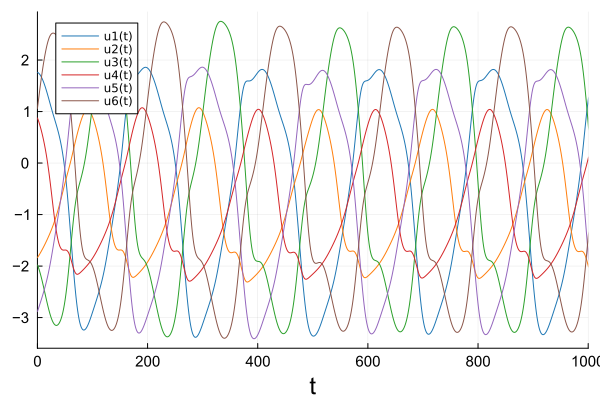

In [58]:
plot(sol, xlims = (0, 1000))

---

## Расачет карты

---

In [57]:
λs = Matrix{Vector{Float64}}(undef, len, len)

@showprogress "Computing..." for i in 1:len
    new_ic = ic
    Threads.@threads for j in reverse(1:len)
        P = [A_ls[i], B, C, Eps_ls[j]]
        
        endstate = get_sol_endstate(ODE, new_ic, 10_000, P, callback; alg, kwargs...)
        if !any(isnan, endstate)
            lvDs = CoupledODEs(ODE, new_ic, P; diffeq)
            tanDs = TangentDynamicalSystem(lvDs)
            λs[i, j] = lyapunovspectrum(tanDs, time_span; Ttr = trans_time);

            new_ic = endstate
        else
            λs[i, j] = fill(NaN, 6)
            new_ic = ic
        end
    end
end

Computing... 100%|███████████████████████████████████████| Time: 0:00:57


---

## Сравнение с бифуркационной диаграммой

---

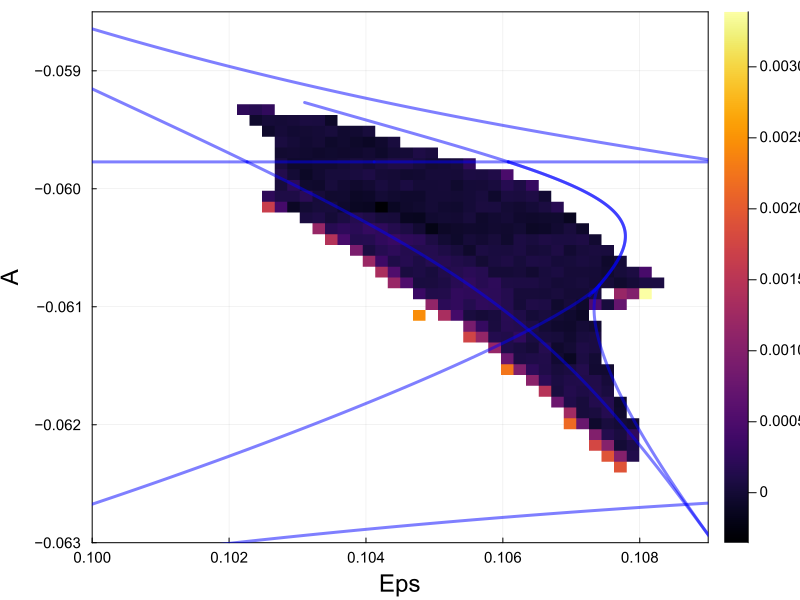

In [37]:
heatmap(Eps_ls, A_ls, [maximum(λ) for λ in λs])
bifcurves!(md, Pair("Eps", "A"), color = "blue", size = (800, 600), xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5)

---

## Разное

---

In [ ]:
bifcurves!(md, Pair("Eps", "A"), color = "blue", size = (800, 600), xlims = (Eps_ls[1], Eps_ls[end]), ylims = (A_ls[1], A_ls[end]), alpha = 0.5)

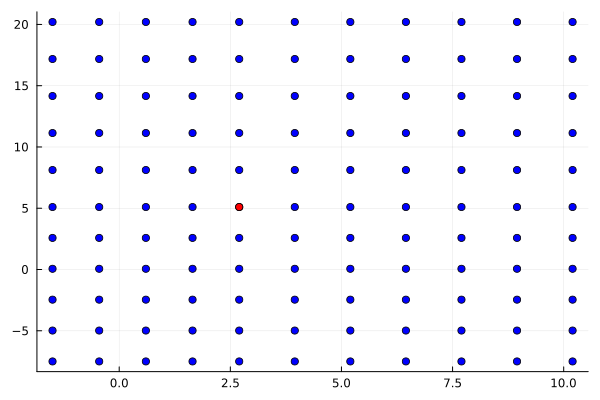

In [255]:
a, i = get_ls_ip(-1.5, 10.2, 2.7, 10)
b, j = get_ls_ip(-7.5, 20.2, 5.1, 10)

x = repeat(a, 1, 11)
y = transpose(repeat(b, 1, 11))

scatter(x, y, legend = false, color = :blue)
scatter!([a[i]], [b[j]], legend = false, color = :red)

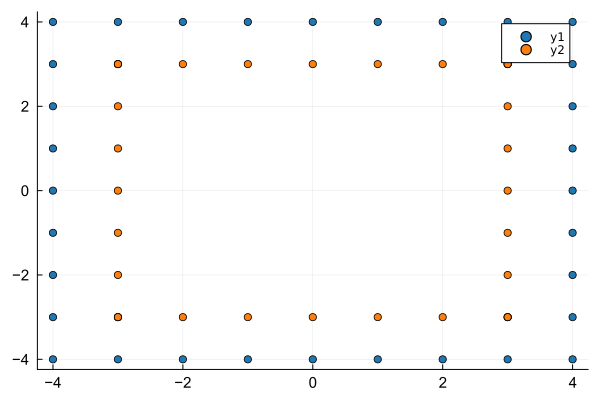

In [364]:
pts = get_rad_idx(4)
prev_pts = [get_prev_idx(p[1], p[2]) for p in pts]

scatter([x[1] for x in pts], [x[2] for x in pts])
scatter!([x[1] for x in prev_pts], [x[2] for x in prev_pts])

---

## Супер протяжка по параметрам

---

In [62]:
λs = Matrix{Vector{Float64}}(undef, size(icpm.p_mesh))
max_vals = Matrix{Vector{Float64}}(undef, size(icpm.p_mesh))
min_vals = Matrix{Vector{Float64}}(undef, size(icpm.p_mesh))

i_shift, j_shift = icpm.idx0

@showprogress "Computing..." for radius in 0:get_radius(icpm)
    Threads.@threads for (i, j) in get_rad_idx(radius)
        cur_icp = icpm[i, j]
        if !isnothing(cur_icp)
            cur_p, cur_ic = cur_icp
            P = [cur_p[1], B, C, cur_p[2]]
            
            endstate_sol = get_sol_endstate(ODE, cur_ic, 30_000, P, callback; alg, kwargs...)
            if !isnothing(endstate_sol)
                lvDs = CoupledODEs(ODE, cur_ic, P; diffeq)
                tanDs = TangentDynamicalSystem(lvDs)

                λs[i_shift + i, j_shift + j] = lyapunovspectrum(tanDs, time_span; Ttr = trans_time);
                max_vals[i_shift + i, j_shift + j] = [maximum(endstate_sol[i, :]) for i in 1:6]
                min_vals[i_shift + i, j_shift + j] = [minimum(endstate_sol[i, :]) for i in 1:6]

                icpm[i, j] = endstate_sol[:, end]
            else
                λs[i_shift + i, j_shift + j] = fill(NaN, 6)
                max_vals[i_shift + i, j_shift + j] = fill(NaN, 6)
                min_vals[i_shift + i, j_shift + j] = fill(NaN, 6)
                icpm[i, j] = icpm[0, 0][2]
            end
        end
    end
end

Computing... 100%|███████████████████████████████████████| Time: 0:01:11


In [51]:
save("./mapdata_1.jld", "lambdas", λs, "max_vals", max_vals, "min_vals", min_vals, "icpm", icpm)

In [42]:
mypalette = [[get(colorschemes[:linear_kbc_5_95_c73_n256], i) for i in range(0, 1, 100)][1:80]; reverse([get(colorschemes[:linear_kry_0_97_c73_n256], i) for i in range(0, 1, 100)])[1:80]]

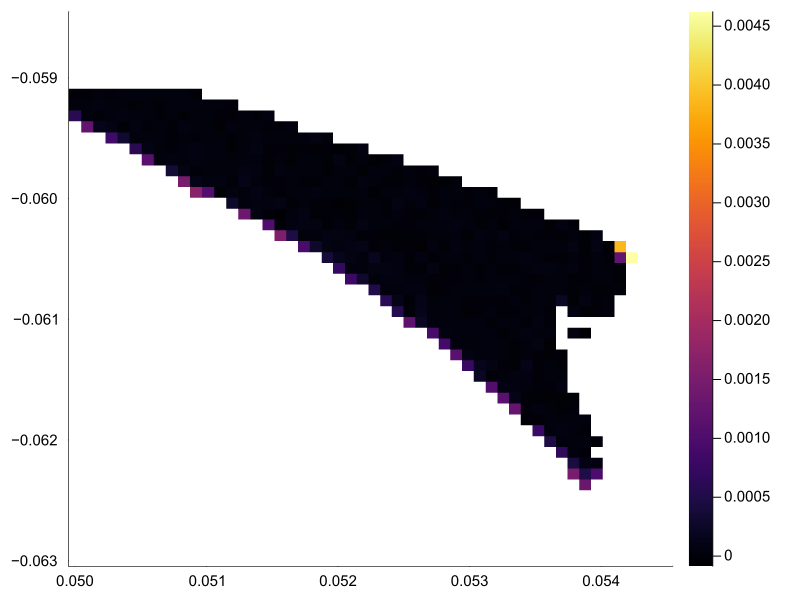

In [65]:
hm = heatmap(Eps_ls, A_ls, [maximum(λ) for λ in λs], right_margin=(10.0, :mm), size = (800, 600)) #,  clims = (-0.0005, 0.0005), , c = :seismic , c=mypalette
#bifcurves!(md, Pair("Eps", "A"), color = "blue", xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5)

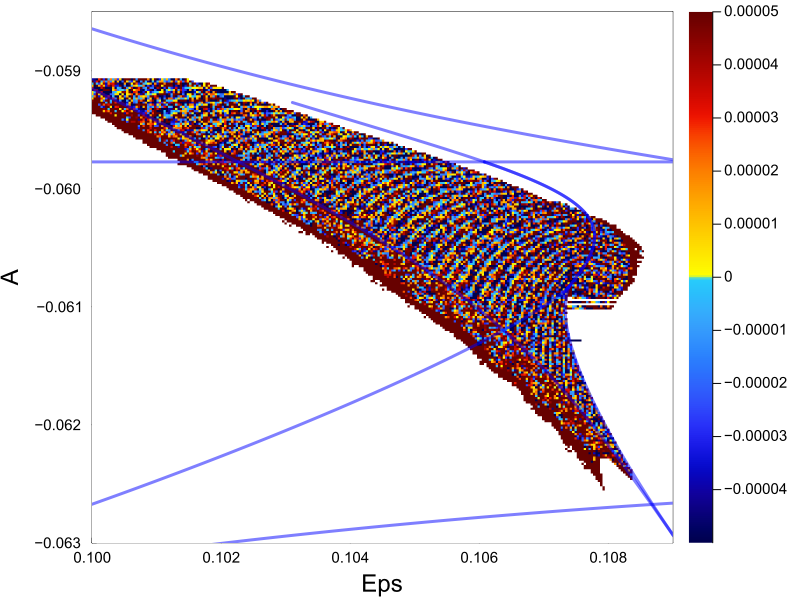

In [190]:
hm = heatmap(Eps_ls, A_ls, [maximum(λ) for λ in λs], right_margin=(10.0, :mm), clims = (-0.00005, 0.00005), c=mypalette) #,  clims = (-0.0005, 0.0005), , c = :seismic
bifcurves!(md, Pair("Eps", "A"), color = "blue", size = (800, 600), xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5)

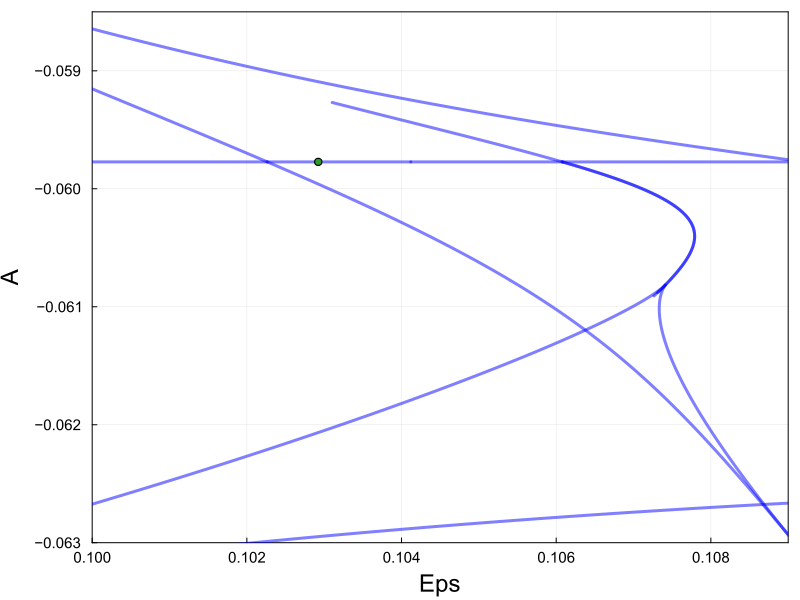

In [22]:
bifcurves(md, Pair("Eps", "A"), color = "blue", size = (800, 600), xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5, clims = (-0.00005, 0.00005))
scatter!([0.10412315329959422-0.0012], [A])

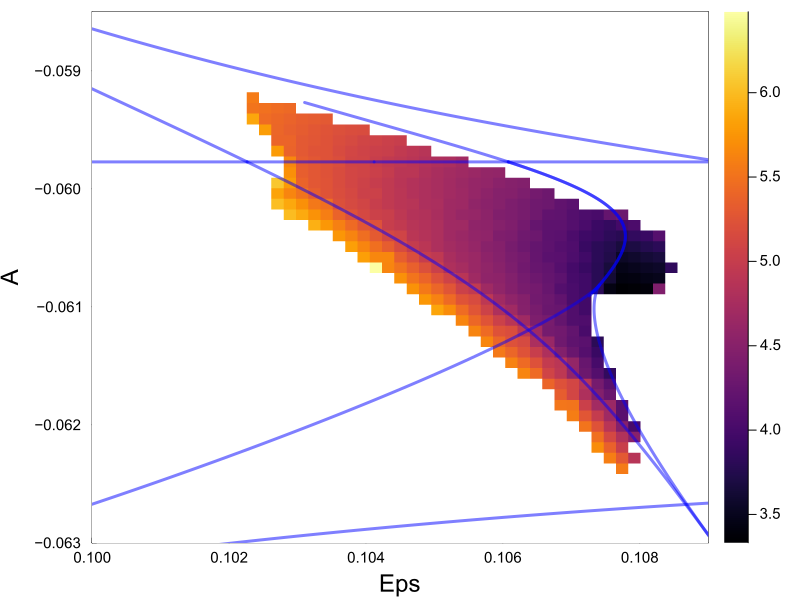

In [16]:
hm = heatmap(Eps_ls, A_ls, [maximum(mv) for mv in max_vals])
bifcurves!(md, Pair("Eps", "A"), color = "blue", size = (800, 600), xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5)

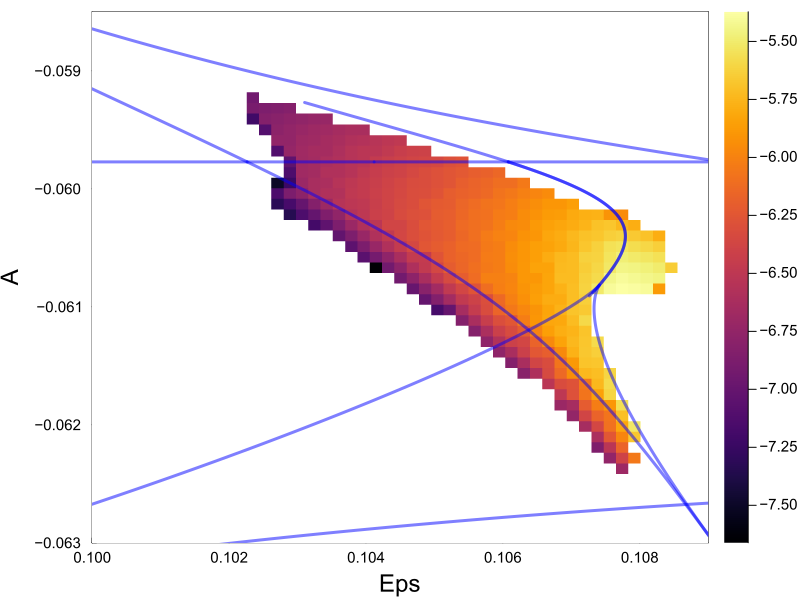

In [18]:
hm = heatmap(Eps_ls, A_ls, [minimum(mv) for mv in min_vals])
bifcurves!(md, Pair("Eps", "A"), color = "blue", size = (800, 600), xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5)

In [19]:
p = plot()

for radius in 0:get_radius(icpm)
    for (i, j) in get_rad_idx(radius)
        cur_icp = icpm[i, j]
        if !isnothing(cur_icp)
            if !isnan(λs[i_shift + i, j_shift + j][1])

                p_i, p_j = get_prev_idx(i, j)
                plot!([p_j, j], [p_i, i], color=radius)
                scatter!([j], [i], color=radius, ms = 2.0)
            end
        end
    end
end

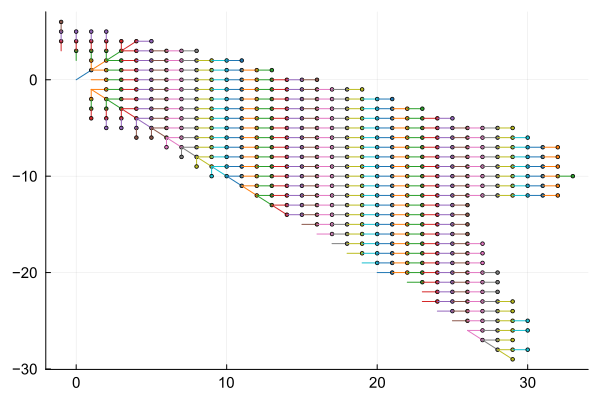

In [20]:
plot(p, legend = false)

In [156]:
data = load(raw"data\mapdata_250x250.jld")
λs = data["lambdas"]
max_vals = data["max_vals"]
min_vals = data["min_vals"]
icpm = data["icpm"]

ICPMEsh([[-0.063, 0.1] [-0.063, 0.10003589831378845] … [-0.063, 0.10896394572576439] [-0.063, 0.109]; [-0.06298196666131049, 0.1] [-0.06298196666131049, 0.10003589831378845] … [-0.06298196666131049, 0.10896394572576439] [-0.06298196666131049, 0.109]; … ; [-0.05851791594893774, 0.1] [-0.05851791594893774, 0.10003589831378845] … [-0.05851791594893774, 0.10896394572576439] [-0.05851791594893774, 0.109]; [-0.0585, 0.1] [-0.0585, 0.10003589831378845] … [-0.0585, 0.10896394572576439] [-0.0585, 0.109]], SVector{6, Float64}[[-0.16893443297416816, -0.9510531328544465, -5.686763598304732, -3.4259081032834136, -0.332661190138586, 4.283911986073268] [-0.16893443297416816, -0.9510531328544465, -5.686763598304732, -3.4259081032834136, -0.332661190138586, 4.283911986073268] … [-0.16893443297416816, -0.9510531328544465, -5.686763598304732, -3.4259081032834136, -0.332661190138586, 4.283911986073268] [-0.16893443297416816, -0.9510531328544465, -5.686763598304732, -3.4259081032834136, -0.332661190138586,